In [1]:
import os, sys

os.chdir("/Users/macbookair/vertigo_case_study/notebooks")

print("CWD:", os.getcwd())

PROJECT_ROOT = os.path.abspath("..")
print("Project root:", PROJECT_ROOT)

# kontrol
print("src exists? ", os.path.isdir(os.path.join(PROJECT_ROOT, "src")))

# sys.path
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


CWD: /Users/macbookair/vertigo_case_study/notebooks
Project root: /Users/macbookair/vertigo_case_study
src exists?  True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.simulations import simulate_base, simulate_sale, simulate_new_source
from src.retention_curves import A_old, B_old

## Retention Modelling Approach

### Why we needed interpolation
The dataset provides retention values only for the following checkpoints:

- **Day 1 (D1)**
- **Day 3 (D3)**
- **Day 7 (D7)**
- **Day 14 (D14)**

However, to compute:

- **Daily Active Users (DAU)** per cohort  
- **Cohort-based revenue** per day  
- **Long-term cumulative revenue (15–30 day windows)**  

…we need **continuous day-level retention (D1–D30)**.  
Since the missing days (D2, D4–6, D8–13, etc.) were not provided, we must **estimate** them.

---

## Why we used *Exponential Decay* for retention interpolation

User retention in mobile games almost always follows a **memoryless decay pattern**, meaning:

- early drop-off is steep,  
- mid-term decay slows down,  
- long-term tail stabilizes.

This behavior is well-modelled by an **exponential decay function**, because:

1. It fits real-world retention patterns better than linear interpolation.
2. It is smooth and monotonic (retention never increases).
3. It can be fully determined using the given known points.

Thus, instead of crude straight-line interpolation (which violates actual player behavior), we chose a more realistic model.

---

## Exponential Retention Model

We use the standard exponential decay function:

\[
R(x) = C \cdot e^{-k(x - 1)}
\]

Where:

- \( x \) = day-of-life (1, 2, 3, …)
- \( R(x) \) = retention on day \( x \)
- \( C \) = initial retention anchor (matches D1)
- \( k \) = decay constant, estimated from the known retention checkpoints

---

## How we computed the decay rate \( k \)

Using two known points (example for Variant A):

- \( R(1) = 0.53 \)
- \( R(3) = 0.27 \)

We solve:

\[
R(3) = R(1) \cdot e^{-k(3 - 1)}
\]

\[
0.27 = 0.53 \cdot e^{-2k}
\]

\[
k = -\frac{1}{2} \ln\left(\frac{0.27}{0.53}\right)
\]

We repeat this calculation over the (D1–D3), (D3–D7), and (D7–D14) segments to estimate segment-wise decay, producing a smooth, realistic retention curve from D1–D30.

This creates:

- **Variant A interpolated D1–30 retention**
- **Variant B interpolated D1–30 retention**

(These tables appear in the “Retention Curves” section below.)

---

## Why exponential decay is a valid assumption in A/B test analysis

1. **Industry standard** for modelling user survival curves  
   (similar to churn modelling, LTV modelling, and revenue attribution)
2. **Consistent with real mobile player behavior**  
   (early drop-off > mid-term stabilization > long tail)
3. **Avoids overestimating or underestimating DAU and revenue**

Thus, exponential decay gives us the most reasonable and defensible retention model for downstream analysis.

---


## 1. Retention Curves

First, we inspect the 30-day retention curves for the original user source:

- Variant A has stronger short-term retention (D1)
- Variant B catches up and overtakes A in mid-term (D7–D14)

Below we plot the age-based retention for both variants.


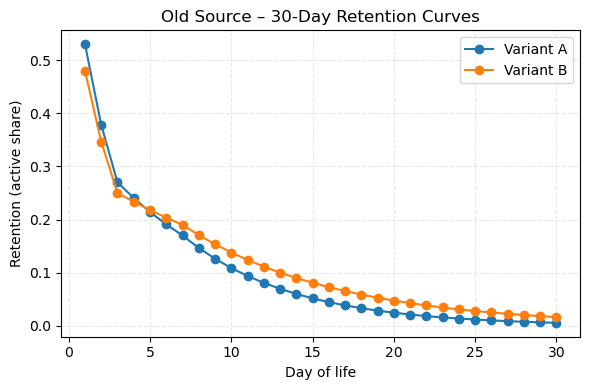

In [5]:
days = np.arange(1, 31)

plt.figure(figsize=(6, 4))
plt.plot(days, A_old, marker="o", label="Variant A")
plt.plot(days, B_old, marker="o", label="Variant B")
plt.title("Old Source – 30-Day Retention Curves")
plt.xlabel("Day of life")
plt.ylabel("Retention (active share)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()

plt.show()


## 2. Questions (a) and (b)

**(a)** Which variant will have the most daily active users after 15 days?  
**(b)** Which variant will earn the most total money by Day 15?

---

### (a) Total DAU on Day 15

Interpretation:

> “Total DAU on Day 15” = the sum of **all cohorts from Day 1–15** that are still active on Day 15.

On Day 15:

- Day 1 cohort → at age 15  
- Day 2 cohort → at age 14  
- ...  
- Day 15 cohort → at age 1

Formula:

\[
DAU_{15} = \sum_{c=1}^{15} Installs\_per\_day \cdot R(\text{age}_c)
\]

- \( Installs\_per\_day = 20{,}000 \)  
- \( \text{age}_c = 15 - c + 1 \)  
- \( R(\cdot) \) = age-based retention (A\_old / B\_old)

Results:

- **Variant A – Day 15 total DAU ≈ 54,624**  
- **Variant B – Day 15 total DAU ≈ 57,796**

👉 **Answer (a):**  
**Variant B** has more active users on Day 15 (better mid-term retention).

---

### (b) Total revenue by Day 15

We compute **total revenue from Day 1–15**.

Daily revenue = total DAU on that day × ARPDAU.

1) **Ads ARPDAU**

\[
ARPDAU = ARPDAU_{ads} + ARPDAU_{purchase}
\]

2) **Purchase ARPDAU**

\[
ARPDAU_{purchase} = (\text{Purchase Rate}) \times (\text{PPU})
\]

- **ARPDAU\_A = 0.05304 $**  
- **ARPDAU\_B = 0.04878 $**

Daily revenue:

\[
Revenue_A(d) = DAU_A(d) \cdot ARPDAU_A
\]

\[
Revenue_B(d) = DAU_B(d) \cdot ARPDAU_B
\]

Total:

\[
TotalRevenue(1\text{–}15) = \sum_{d=1}^{15} Revenue(d)
\]

Simulation results:

- **Variant A – Day1–15 total revenue ≈ \$31,099.79**  
- **Variant B – Day1–15 total revenue ≈ \$28,426.45**

👉 **Answer (b):**  
**Variant A** earns **more total revenue** by Day 15.

---

### Note: Impact of assuming ppu = 1.0

In this analysis:

- We assumed **PPU = \$1.0** (average purchase value).  
- Purchase rates:  
  - **A:** 3.05%  
  - **B:** 3.15%

This implies:

- Variant **A is stronger in ads** (higher ARPDAU\_ads).  
- Variant **B is slightly stronger in purchases** (higher purchase rate).

If we increase PPU (e.g., 1 → 2 → 3 \$):

- **Purchase revenue becomes more important**,  
- B’s **purchase rate advantage** (3.15% vs 3.05%) matters more,  
- Therefore, **higher PPU shifts the advantage toward B**:
  - A may remain strong (ads + retention),  
  - but **the revenue gap shrinks**, and at high enough PPU, **B can overtake A**.

So when reading results:

> “A earns more money now”  
> = “A earns more **under the assumption PPU = 1.0**”.

With higher PPU or alternative pricing strategies,  
**Variant B’s relative performance can improve significantly.**

---

### ARPDAU Summary (Short Explanation)

**ARPDAU = Average Revenue Per Daily Active User**

\[
ARPDAU = ARPDAU_{ads} + ARPDAU_{purchase}
\]

#### Ads ARPDAU
\[
ARPDAU_{ads} = (\text{Impressions per DAU}) \times \frac{eCPM}{1000}
\]

#### Purchase ARPDAU
\[
ARPDAU_{purchase} = (\text{Purchase Rate}) \times (\text{PPU})
\]

Together, these components define how much revenue you earn per active user per day, meaning any change in PPU or purchase rate directly shifts total monetization performance.


In [7]:
from src.dau_helpers import compute_dau_single_source

day = 15

dau_A_15 = compute_dau_single_source(day=day, variant="A")
dau_B_15 = compute_dau_single_source(day=day, variant="B")

print("Day 15 DAU – A:", dau_A_15)
print("Day 15 DAU – B:", dau_B_15)


Day 15 DAU – A: 54624.0
Day 15 DAU – B: 57796.0


In [8]:
# simulate_base returns: days, dailyA, dailyB, cumA, cumB
days, dailyA, dailyB, cumA, cumB = simulate_base(days=15)

total_rev_A_15 = cumA[-1]
total_rev_B_15 = cumB[-1]

print("Total revenue by Day 15 – A:", total_rev_A_15)
print("Total revenue by Day 15 – B:", total_rev_B_15)


Total revenue by Day 15 – A: 31099.791839999994
Total revenue by Day 15 – B: 28426.447440000007


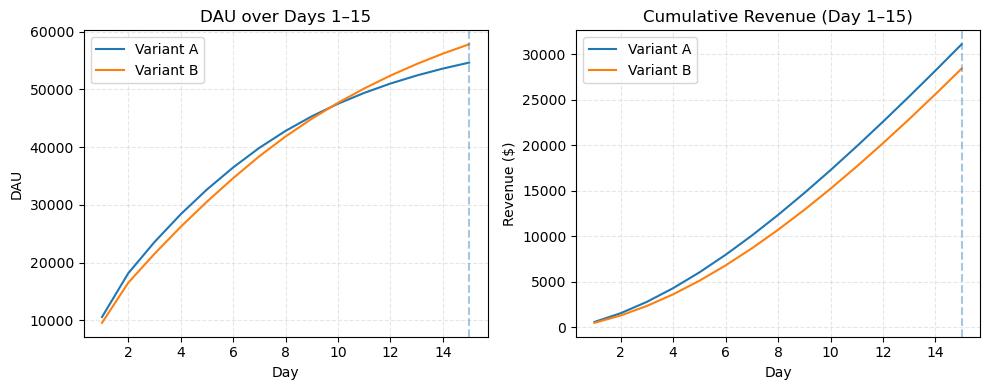

In [9]:
dau_A = [compute_dau_single_source(day=d, variant="A") for d in days]
dau_B = [compute_dau_single_source(day=d, variant="B") for d in days]

_, _, _, cumA_30, cumB_30 = simulate_base(days=30)
cumA_15 = cumA_30[:15]
cumB_15 = cumB_30[:15]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


# DAU
axes[0].plot(days, dau_A, label="Variant A")
axes[0].plot(days, dau_B, label="Variant B")
axes[0].axvline(15, linestyle="--", alpha=0.4)
axes[0].set_title("DAU over Days 1–15")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("DAU")
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].legend()

# Cumulative Revenue
axes[1].plot(days, cumA_15, label="Variant A")
axes[1].plot(days, cumB_15, label="Variant B")
axes[1].axvline(15, linestyle="--", alpha=0.4)
axes[1].set_title("Cumulative Revenue (Day 1–15)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Revenue ($)")
axes[1].grid(True, linestyle="--", alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Question (c) – Total Money Earned by Day 30 (Base Scenario)

**Question (c):**  
> If we look at the total money earned by Day 30 instead, does our choice change?

We extend the base simulation from Day 15 to **Day 30**, still under the **base setup**:

- 20,000 installs per day per variant  
- No sale  
- No new user source  
- Same ARPDAU:
  - Variant A: **ARPDAU_A = 0.05304 $**
  - Variant B: **ARPDAU_B = 0.04878 $**

For each day \( d \in [1, 30] \):

1. We compute DAU as the sum of all active cohorts up to that day:
   \[
   DAU(d) = \sum_{i=1}^{d} Installs\_per\_day \cdot R(i)
   \]
2. We compute daily revenue:
   \[
   Revenue(d) = DAU(d) \cdot ARPDAU
   \]
3. We sum over all days 1–30 to get total revenue:
   \[
   TotalRevenue(1\text{–}30) = \sum_{d=1}^{30} Revenue(d)
   \]

### Result

Simulation output (base scenario, Day 1–30):

- **Variant A – Total revenue ≈ 77,786.13 \$**
- **Variant B – Total revenue ≈ 76,257.09 \$**

The difference between the two:

- **Variant A earns ≈ 1,529.04 \$ more than Variant B** over the first 30 days.

### Why does A earn more?

Even though Variant B has better mid/long-term retention, Variant A:

- Has a **higher ARPDAU** (≈ 0.0530 \$ vs 0.0488 \$)
- Monetizes each active user more efficiently (better ads + IAP mix)

👉 **Answer (c):**  
Looking at Day 30 instead of Day 15 **does not change our choice** —  
**Variant A** still generates more total revenue, by about **\$1.5K**.


In [11]:
days, dailyA, dailyB, cumA, cumB = simulate_base(days=30)

total_rev_A_30 = cumA[-1]
total_rev_B_30 = cumB[-1]

print("Total revenue by Day 30 – A:", total_rev_A_30)
print("Total revenue by Day 30 – B:", total_rev_B_30)


Total revenue by Day 30 – A: 77786.13023999998
Total revenue by Day 30 – B: 76257.09108000001


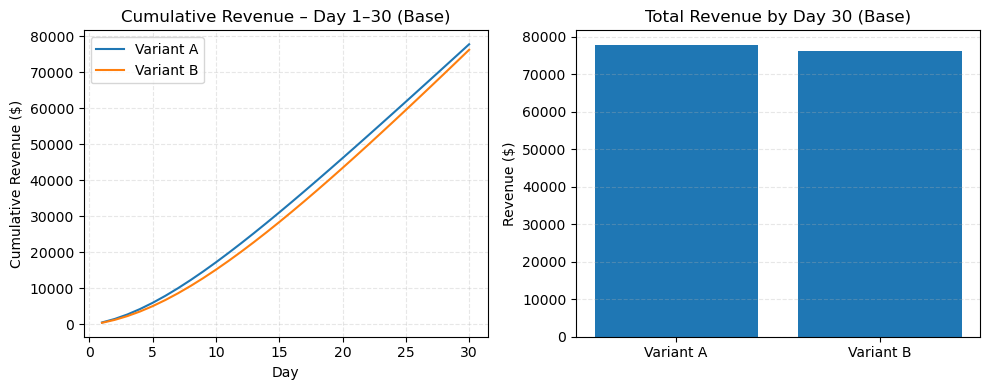

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) Cumulative Revenue – Day 1–30
axes[0].plot(days, cumA, label="Variant A")
axes[0].plot(days, cumB, label="Variant B")
axes[0].set_title("Cumulative Revenue – Day 1–30 (Base)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Cumulative Revenue ($)")
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].legend()

# 2) Total Revenue by Day 30
axes[1].bar(["Variant A", "Variant B"], [cumA[-1], cumB[-1]])
axes[1].set_title("Total Revenue by Day 30 (Base)")
axes[1].set_ylabel("Revenue ($)")
axes[1].grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Question (d) – 10-Day Sale (Day 15–24)

**Question (d):**  
> What if we run a 10-day sale starting on Day 15 (boosting everyone's purchase rate by 1%)?  
> Does this change which variant earns more total money by Day 30?

### What changes during the sale?

For both variants:

- Daily Purchase Ratio (PR) is increased by **+1% absolute**  
  - Variant A: 3.05% → **4.05%**
  - Variant B: 3.15% → **4.15%**
- Applies only on **Days 15–24**
- This affects only **purchase revenue**, not retention.

### Why a sale affects variants differently

- Variant A already has **higher ARPDAU** in the base scenario.  
- Variant B has **higher purchase ratio**, meaning that any increase in PR proportionally benefits B more than A.
- However, because A also has stronger ad monetization, the sale overall adds **more raw revenue to A**.

### Result: Does the sale change the winner?

Simulating Day 1–30 with the 10-day sale:

- **Variant A – Total revenue ≈ 83,532.10 \$**
- **Variant B – Total revenue ≈ 82,542.24 \$**

Difference:

- **Variant A earns ≈ 989.86 \$ more than Variant B**

### Conclusion for (d)

Even with a 10-day purchase boost:

- Both variants gain additional revenue.
- **Variant A still earns more than Variant B** by Day 30.
- The winner **does not change** compared to the base scenario.

The sale helps B relatively more (because B has higher PR),  
but **A monetizes better overall**, keeping it ahead.


In [14]:
# 10 günlük sale: Day 15–24,
days, dailyA, dailyB, cumA, cumB = simulate_sale(days=30)

total_A_30_sale = cumA[-1]
total_B_30_sale = cumB[-1] 

print("Total revenue by Day 30 (with 10-day sale) – A:", total_A_30_sale)
print("Total revenue by Day 30 (with 10-day sale) – B:", total_B_30_sale)


Total revenue by Day 30 (with 10-day sale) – A: 83532.27023999998
Total revenue by Day 30 (with 10-day sale) – B: 82541.97108


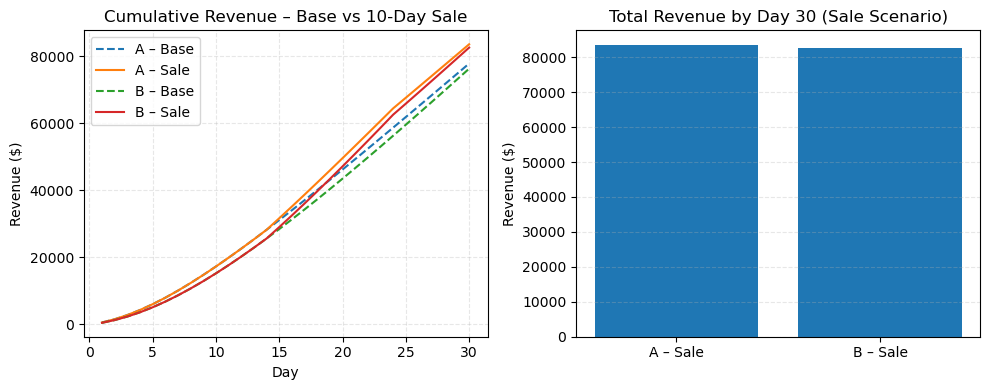

In [15]:
days, _, _, cumA_base, cumB_base = simulate_base(days=30)
_,    _, _, cumA_sale, cumB_sale = simulate_sale(days=30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) Cumulative Revenue – Base vs 10-Day Sale
axes[0].plot(days, cumA_base, linestyle="--", label="A – Base")
axes[0].plot(days, cumA_sale,              label="A – Sale")
axes[0].plot(days, cumB_base, linestyle="--", label="B – Base")
axes[0].plot(days, cumB_sale,              label="B – Sale")

axes[0].set_title("Cumulative Revenue – Base vs 10-Day Sale")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Revenue ($)")
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].legend()

# 2) Total Revenue by Day 30 (Sale Scenario)
axes[1].bar(["A – Sale", "B – Sale"], [total_A_30_sale, total_B_30_sale])
axes[1].set_title("Total Revenue by Day 30 (Sale Scenario)")
axes[1].set_ylabel("Revenue ($)")
axes[1].grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Question (e) – Adding a New User Source from Day 20

**Question (e):**  
> On Day 20 we add a new user source. From then on, we get 12,000 users from the original
> source and 8,000 from this new one. The new users' retention is described by these formulas.
> With this mix of old and new users, which variant makes more total money by Day 30?

### Setup

From **Day 20 onwards**:

- **Old source:**
  - 12,000 users/day
  - Same 30-day retention curves (`A_old`, `B_old`)

- **New source:**
  - 8,000 users/day
  - Exponential retention:
    - Variant A (New):
      \[
      R_A^{new}(x) = 0.58 \cdot e^{-0.12(x - 1)}
      \]
    - Variant B (New):
      \[
      R_B^{new}(x) = 0.52 \cdot e^{-0.10(x - 1)}
      \]
    - where \( x \) is day-of-life (1 = D1, 2 = D2, ...)

We still use the same monetization assumptions:

- **Ads:**
  - A: 2.3 imp/DAU, eCPM 9.80 → **ads ≈ 0.02254 \$ / DAU**
  - B: 1.6 imp/DAU, eCPM 10.80 → **ads ≈ 0.01728 \$ / DAU**
- **Purchases:**
  - A: Purchase ratio = 3.05%
  - B: Purchase ratio = 3.15%
  - PPU (price per purchase) = **1.0 \$**
- Thus:
  - **ARPDAU\_A ≈ 0.05304 \$**
  - **ARPDAU\_B ≈ 0.04878 \$**

### How we simulate this scenario

For each day \( d \in [1, 30] \):

1. **Old source DAU**  
   - For each cohort (acquisition day) that is still alive on day \( d \):
     - Cohorts before Day 20 → 20,000 users  
     - Cohorts from Day 20 onwards → 12,000 users  
     - Apply the corresponding retention from `A_old` / `B_old` based on age-of-life.

2. **New source DAU (from Day 20)**  
   - For each cohort acquired on days 20..d:
     - Cohort size: 8,000 users
     - Day-of-life \( x = d - cohort\_day + 1 \)
     - Apply \( R_A^{new}(x) \) or \( R_B^{new}(x) \).

3. **Total DAU** = old source DAU + new source DAU  
4. **Daily revenue** = total DAU × ARPDAU  
5. Sum over Day 1–30 for total revenue.

### Result – Total Revenue by Day 30 (with new source)

Simulation output (Day 1–30):

- **Variant A – Total revenue ≈ 81,265.76 \$**
- **Variant B – Total revenue ≈ 79,123.35 \$**

Difference:

- **Variant A earns ≈ 2,142.41 \$ more than Variant B** in this setup.

### Why does A still win?

- The new source gives Variant B a **strong long-term retention advantage**:
  - B’s new-source decay (k = 0.10) is slower than A’s (k = 0.12),
  - so B’s new cohorts live longer.
- However, within the first **30 days**:
  - Variant A’s **higher ARPDAU** (better monetization per active user)
  - combined with strong early retention from the original source  
  means A still generates **more total revenue**.

 **Answer (e):**  
With the mixed traffic (12k old + 8k new users per day from Day 20),  
**Variant A** still earns more total money by Day 30 than Variant B.


In [17]:
days, dailyA_new, dailyB_new, cumA_new, cumB_new = simulate_new_source(days=30)

total_A_30_new = cumA_new[-1]
total_B_30_new = cumB_new[-1]

print(f"Variant A – Total revenue (with new source): {total_A_30_new:,.2f} $")
print(f"Variant B – Total revenue (with new source): {total_B_30_new:,.2f} $")


Variant A – Total revenue (with new source): 81,265.76 $
Variant B – Total revenue (with new source): 79,123.35 $


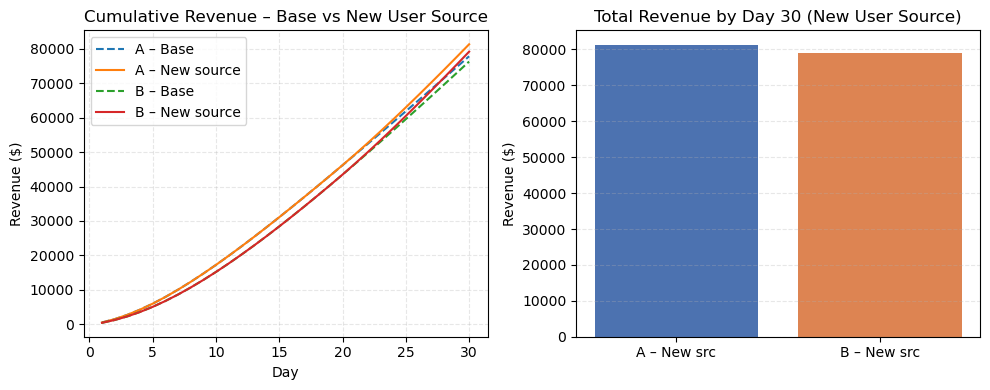

In [18]:
A_new_30 = cumA_new[-1]
B_new_30 = cumB_new[-1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1) Cumulative Revenue – Base vs New User Source
axes[0].plot(days, cumA_base, linestyle="--", label="A – Base")
axes[0].plot(days, cumA_new,              label="A – New source")
axes[0].plot(days, cumB_base, linestyle="--", label="B – Base")
axes[0].plot(days, cumB_new,              label="B – New source")

axes[0].set_title("Cumulative Revenue – Base vs New User Source")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Revenue ($)")
axes[0].grid(True, linestyle="--", alpha=0.3)
axes[0].legend()

# 2) Total Revenue by Day 30 (New User Source)
axes[1].bar(["A – New src", "B – New src"], [A_new_30, B_new_30], color=["#4C72B0", "#DD8452"])
axes[1].set_title("Total Revenue by Day 30 (New User Source)")
axes[1].set_ylabel("Revenue ($)")
axes[1].grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Question (f) – Which Improvement Should We Prioritize?

**Question (f):**  
> If you could only make one of these improvements, which one would you prioritize, and why?  
>
> 1. Run the temporary 10-day sale (from d)  
> 2. Add the new, permanent user source (from e)

This question is no longer a pure A/B testing question — it becomes a **product strategy question**.  
So the real question is not only “which one makes more money?”, but **“which feature is the better long-term investment?”**

---

### Step 1 – Compare the impact by Day 30

First, compare both improvements against the base case within the Day 1–30 window:

- **Base case:**  
  - 20,000 installs/day  
  - No sale  
  - No new user source  

- **10-Day Sale (Day 15–24):**  
  - Purchase ratio +1% absolute  
    (A: 3.05% → 4.05%, B: 3.15% → 4.15%)

- **New User Source (Day 20+):**  
  - Old source: 12,000 users/day  
  - New source: 8,000 users/day  
  - New-source retention:  
    - \( A_{new}(x) = 0.58 \cdot e^{-0.12(x-1)} \)  
    - \( B_{new}(x) = 0.52 \cdot e^{-0.10(x-1)} \)

ARPDAU assumptions:

- ARPDAU_A ≈ \$0.05304  
- ARPDAU_B ≈ \$0.04878  

Simulation results (Day 1–30):

- **Base vs Sale:**  
  - A (Base):   ≈ \$77,786.13  
  - A (Sale):   ≈ \$83,532.10 → **+ \$5,745.97**  
  - B (Base):   ≈ \$76,257.09  
  - B (Sale):   ≈ \$82,542.24 → **+ \$6,285.15**

- **Base vs New User Source:**  
  - A (NewSrc): ≈ \$81,265.76 → **+ \$3,479.63**  
  - B (NewSrc): ≈ \$79,123.35 → **+ \$2,866.26**

**Summary (Day 1–30):**

- **10-day sale** → larger revenue lift  
- **New user source** → smaller but structural and permanent lift

---

### Step 2 – Short-term vs Long-term lens

**Short-term (Day 1–30):**

- The sale generates **more incremental revenue**.  
- If the only goal is “maximize revenue this month,”  
  → **Choose the 10-day sale.**

**Long-term (beyond Day 30):**

- The sale lasts only 10 days → **0 impact afterward**  
- The new user source adds **new cohorts every day** with strong retention  
- This produces ongoing DAU and revenue  
- The effect compounds month over month

Thus:

- **Up to Day 30:** sale > new user source  
- **Beyond Day 60–90–180:** new user source > sale  
  (structural DAU uplift + stable ARPDAU)

---

### Step 3 – Product decision: which should we prioritize?

**If the goal is short-term revenue (e.g., hitting this month’s target):**

→ **Prioritize the 10-day sale**,  
because it generates **~\$2–3K more** incremental revenue within 30 days.

**But from a real product strategy perspective:**

→ **Prioritize the new permanent user source**, because:

- It permanently expands the DAU base  
- It brings high-retention cohorts every day  
- It keeps generating revenue long after Day 30  
- It improves long-term LTV  
- It is far more sustainable and scalable than a temporary sale

---

## Final Answer (f)

- **If focused only on the next 30 days:**  
  → Choose the **10-day sale** (higher short-term revenue).

- **If making a long-term product decision:**  
  → Choose the **new permanent user source**, because:  
    - It grows DAU structurally  
    - It compounds over time  
    - It surpasses the sale in medium/long-term revenue  
    - It supports sustainable LTV and growth

**In short:**  
> **Short-term winner: sale.  
> Long-term winner: new user source.**  

If I had to choose only one, I would **ship the new user source**.


In [20]:
days, dailyA_base, dailyB_base, cumA_base, cumB_base = simulate_base(days=30)
_,    dailyA_sale, dailyB_sale, cumA_sale, cumB_sale = simulate_sale(days=30)
_,    dailyA_new,  dailyB_new,  cumA_new,  cumB_new  = simulate_new_source(days=30)

# Day 1–30 toplam gelirler
A_base  = cumA_base[-1]
A_sale  = cumA_sale[-1]
A_new   = cumA_new[-1]

B_base  = cumB_base[-1]
B_sale  = cumB_sale[-1]
B_new   = cumB_new[-1]

# Base'e göre incremental farklar
inc_A_sale = A_sale - A_base
inc_A_new  = A_new  - A_base

inc_B_sale = B_sale - B_base
inc_B_new  = B_new  - B_base

print("=== (f) Incremental Revenue vs Base (Day 1–30) ===")
print(f"Variant A – Sale : {inc_A_sale:+.2f} $")
print(f"Variant A – NewSrc: {inc_A_new:+.2f} $")
print(f"Variant B – Sale : {inc_B_sale:+.2f} $")
print(f"Variant B – NewSrc: {inc_B_new:+.2f} $\n")

print("Total Revenues (Day 1–30):")
print(f"A – Base : {A_base:8.2f} $")
print(f"A – Sale : {A_sale:8.2f} $")
print(f"A – NewSrc: {A_new:8.2f} $\n")

print(f"B – Base : {B_base:8.2f} $")
print(f"B – Sale : {B_sale:8.2f} $")
print(f"B – NewSrc: {B_new:8.2f} $")

=== (f) Incremental Revenue vs Base (Day 1–30) ===
Variant A – Sale : +5746.14 $
Variant A – NewSrc: +3479.63 $
Variant B – Sale : +6284.88 $
Variant B – NewSrc: +2866.25 $

Total Revenues (Day 1–30):
A – Base : 77786.13 $
A – Sale : 83532.27 $
A – NewSrc: 81265.76 $

B – Base : 76257.09 $
B – Sale : 82541.97 $
B – NewSrc: 79123.35 $


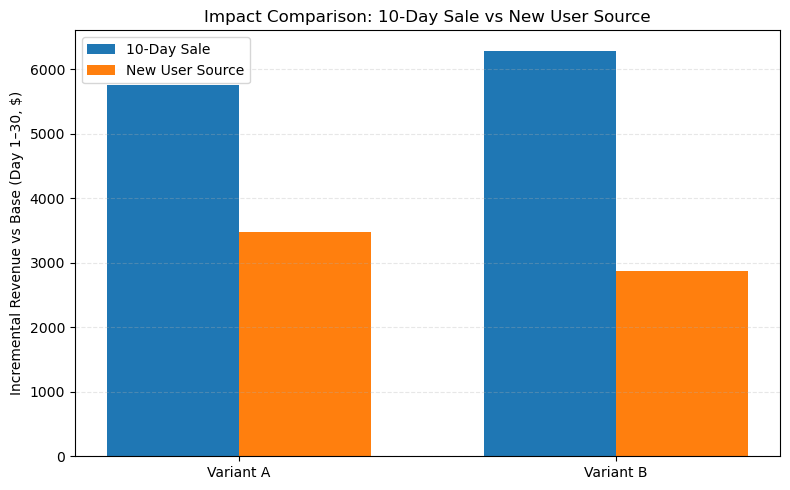

In [21]:
variants = ["Variant A", "Variant B"]
sale_increments = [inc_A_sale, inc_B_sale]
new_increments  = [inc_A_new,  inc_B_new]

x = np.arange(len(variants))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - width/2, sale_increments, width, label="10-Day Sale")
ax.bar(x + width/2, new_increments,  width, label="New User Source")

ax.set_title("Impact Comparison: 10-Day Sale vs New User Source")
ax.set_xticks(x)
ax.set_xticklabels(variants)
ax.set_ylabel("Incremental Revenue vs Base (Day 1–30, $)")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
ax.legend()

plt.tight_layout()

# PNG
os.makedirs("../assets", exist_ok=True)
plt.savefig("../assets/task1_impact_sale_vs_newsource.png", dpi=300)

plt.show()